In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import time

In [2]:
def logdet(M):
    slogdet_M = la.slogdet(M)
    return slogdet_M[0]*slogdet_M[1]

def tsp(M):
    return np.transpose(M)

def inv(M):
    return la.inv(M)

def LSE(x):
    n = len(x)
    f = 0
    for i in range(n):
        f += np.exp(x[i])
    return np.log(f)

def LSE_m(x):
    y = x-max(x)
    return LSE(y)+max(x)

In [3]:
def mvpo_egd(μ,Σ,γ,K,η):
    N = len(μ)
    w_hist = np.zeros((K,N))
    u_hist = np.zeros(K)
    w_curr = np.ones(N)/N
    for k in range(K):
        g_curr = γ*Σ@w_curr-μ
        w_next = np.zeros(N)
        w_norm = 0
        for i in range(N):
            w_norm += w_curr[i]*np.exp(-η*g_curr[i])
        for i in range(N):
            w_next[i] = (w_curr[i]*np.exp(-η*g_curr[i]))/w_norm
        w_hist[k,:] = w_next
        u_hist[k] = w_next@μ-0.5*γ*w_next@Σ@w_next
        w_curr = w_next
    return w_hist[-1], w_hist, u_hist

In [4]:
class rsfm_fit_inf():
    
    def __init__(self,likelihood,prediction,filtering,smoothing):
        self.likelihood = likelihood
        self.prediction = prediction
        self.filtering = filtering
        self.smoothing = smoothing

class rsfm_fit_out():
    
    def __init__(self,α,B,σ,p,P,observed,PLL_hist,OLL_hist,AIC,BIC):
        self.α = α
        self.B = B
        self.σ = σ
        self.p = p
        self.P = P
        self.observed = observed
        self.PLL_hist = PLL_hist
        self.OLL_hist = OLL_hist
        self.AIC = AIC
        self.BIC = BIC
        
    def save(self,filename):
        rsfm_inf = self.inference()
        np.savez(filename,alpha=self.α,beta=self.B,sigma=self.σ,p=self.p,
                 P=self.P,observed=self.observed,PLL_hist=self.PLL_hist,
                 OLL_hist=self.OLL_hist,AIC=self.AIC,BIC=self.BIC,
                 likelihood=rsfm_inf.likelihood,prediction=rsfm_inf.prediction,
                 filtering=rsfm_inf.filtering,smoothing=rsfm_inf.smoothing)
        
    def inference(self):
        
        # create matrices to store probabilities
        T = self.observed.shape[0]
        S = self.observed.shape[1]
        likelihood = self.observed
        prediction = np.zeros((T+1,S))
        filtering = np.zeros((T,S))
        smoothing = np.zeros((T,S)) 

        # compute prediction and filtering probabilities
        prediction[0,:] = self.p
        for t in range(T):
            # compute total for filtering
            log_prediction_iter = np.zeros(S)
            for s in range(S):
                log_prediction_iter[s] = np.log(max(prediction[t,s],1e-100))+likelihood[t,s]
            log_prediction_total = LSE_m(log_prediction_iter)
            # compute filtering
            for s in range(S):
                filtering[t,s] = np.exp(np.log(max(prediction[t,s],1e-100))+likelihood[t,s]-log_prediction_total)
            # compute prediction
            for s in range(S):
                for sprime in range(S):
                    prediction[t+1,s] += filtering[t,sprime]*self.P[sprime,s]

        # compute smoothing probabilities
        for t in range(T-1,0-1,-1):
            for s in range(S):
                for sprime in range(S):
                    if t == T-1:
                        smoothing[t,s] += self.P[s,sprime]*prediction[t+1,sprime]/prediction[t+1,sprime]
                    else:
                        smoothing[t,s] += self.P[s,sprime]*smoothing[t+1,sprime]/prediction[t+1,sprime]
                smoothing[t,s] = smoothing[t,s]*filtering[t,s]
        
        return rsfm_fit_inf(likelihood,prediction,filtering,smoothing)

In [5]:
def fm_fit(r,F):
    
    # set dimensions
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record estimates
    α = np.zeros(N)
    B = np.ones((N,M))
    σ = np.ones(N)
    p = 1
    P = 1
    observed = np.zeros(T)
    PLL_hist = 0
    OLL_hist = 0
    
    # estimate parameters
    for i in range(N):
        y = r[:,i]
        X = np.column_stack((np.ones(T),F))
        mod = sm.OLS(y,X)
        res = mod.fit()
        α[i] = res.params[0]
        B[i,:] = res.params[1:(M+1)]
        σ[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(T)
    
    Ω = np.diag(σ**2)
    for t in range(T):
        e_t = r[t,:]-α-B@F[t,:]
        observed[t] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω)-0.5*e_t@inv(Ω)@e_t
        
    PLL_hist = np.sum(observed)/T
    OLL_hist = np.sum(observed)/T
    
    AIC = -2*T*OLL_hist+2*(N+N*M+N)
    BIC = -2*T*OLL_hist+np.log(T)*(N+N*M+N)
    
    return rsfm_fit_out(α,B,σ,p,P,observed,PLL_hist,OLL_hist,AIC,BIC)

In [6]:
def rsfm_fit(r,F,S,N_ITER,N_INIT,seed=0,verbose=2,init_noise_scale=np.array([0.5,0.5,5])):
    
    ## INITIALIZATION ###
    
    # set seed and dimensions
    np.random.seed(seed)
    T = r.shape[0]
    N = r.shape[1]
    M = F.shape[1]
    
    # record best estimates
    α_best = np.zeros((S,N))
    B_best = np.ones((S,N,M))
    σ_best = np.ones((S,N))
    p_best = np.ones(S)/S
    P_best = np.ones((S,S))/S**2
    observed_best = np.zeros((T,S))
    PLL_hist_best = np.zeros(N_ITER)
    OLL_hist_best = np.zeros(N_ITER)
    OLL_best = -np.inf

    ### ESTIMATE PARAMETERS ###
    
    for init in range(N_INIT):
        
        time_init_0 = time.time()
        
        # randomly initialize factor model parameters
        α = np.zeros((S,N))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[0],size=S*N),(S,N))
        B = np.ones((S,N,M))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[1],size=S*N*M),(S,N,M))
        σ = np.reshape(np.random.chisquare(df=init_noise_scale[2],size=S*N),(S,N))
        
        # randomly initialize Markov chain parameters
        p = np.random.rand(S)
        p = p/np.sum(p)
        P = np.random.rand(S,S)
        for s in range(S):
            P[s,:] = P[s,:]/np.sum(P[s,:])
            
        # create likelihood histories
        PLL_hist = np.zeros(N_ITER)
        OLL_hist = np.zeros(N_ITER)
            
        # iterative updates
        for n in range(N_ITER):
            
            time_iter_0 = time.time()
            
            try:    
                    
                ### EXPECTATION STEP ###
                
                # compute observed log-densities
                observed = np.zeros((T,S))
                for s in range(S):
                    α_s = α[s,:]
                    B_s = B[s,:,:]
                    Ω_s = np.diag(σ[s,:]**2)
                    for t in range(T):
                        e_st = r[t,:]-α_s-B_s@F[t,:]
                        observed[t,s] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω_s)-0.5*e_st@inv(Ω_s)@e_st
                
                # compute forward log-densities
                log_forward = np.zeros((T,S))
                for s in range(S):
                    log_forward[0,s] = np.log(max(p[s],1e-100))+observed[0,s]
                for t in range(1,T):
                    for s in range(S):
                        log_forward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_forward_iter[sprime] = log_forward[t-1,sprime]+np.log(max(P[sprime,s],1e-100))+observed[t,s]
                        log_forward[t,s] = LSE_m(log_forward_iter)

                # compute backward log-densities
                log_backward = np.zeros((T,S))
                for t in range(T-2,0-1,-1):
                    for s in range(S):
                        log_backward_iter = np.zeros(S)
                        for sprime in range(S):
                            log_backward_iter[sprime] = log_backward[t+1,sprime]+np.log(max(P[s,sprime],1e-100))+observed[t+1,sprime]
                        log_backward[t,s] = LSE_m(log_backward_iter) 

                # compute posterior marginal log-densities for latent variables
                log_q = np.zeros((T,S))
                for t in range(T):
                    for s in range(S):
                        log_q_total = np.zeros(S)
                        for sprime in range(S):
                            log_q_total[sprime] = log_forward[t,sprime]+log_backward[t,sprime]
                        log_q[t,s] = log_forward[t,s]+log_backward[t,s]-LSE_m(log_q_total)

                # compute posterior transition log-densities for latend variables
                log_Q = np.zeros((T-1,S,S))
                for t in range(T-1):
                    for s in range(S):
                        for sprime in range(S):
                            log_Q_total = np.zeros((S,S))
                            for j in range(S):
                                for k in range(S):
                                    log_Q_total[j,k] = log_forward[t,j]+np.log(max(P[j,k],100))+log_backward[t+1,k]+observed[t+1,k]
                            log_Q_total = log_Q_total.flatten()
                            log_Q[t,s,sprime] = log_forward[t,s]+np.log(max(P[s,sprime],100))+log_backward[t+1,sprime]+observed[t+1,sprime]-LSE_m(log_Q_total)
                
                ### MAXIMIZATION STEP (FACTOR MODEL) ###

                # create new iterates
                α_new = np.zeros((S,N))
                B_new = np.ones((S,N,M))
                σ_new = np.zeros((S,N))
                    
                # compute new iterates
                q = np.exp(log_q)
                for s in range(S):
                    # compute total weighted probability for state s
                    q_s_total = 0
                    for t in range(T):
                        q_s_total += q[t,s]
                    # create weighted factor matrix for state s
                    φ_s = np.zeros((T,M+1))
                    for t in range(T):
                        for m in range(M+1):
                            if m == 0:
                                φ_s[t,m] = q[t,s]**0.5
                            else:
                                φ_s[t,m] = q[t,s]**0.5*F[t,m-1]
                    for i in range(N):
                        # create weighted returns for asset i in state s
                        r_tilde_si = np.zeros(T)
                        for t in range(T):
                            r_tilde_si[t] = q[t,s]**0.5*r[t,i]
                        # compute factor model parameters  
                        β_si = inv(tsp(φ_s)@φ_s)@tsp(φ_s)@r_tilde_si
                        α_new[s,i] = β_si[0]
                        B_new[s,i,:] = β_si[1:]
                        σ_new[s,i] = la.norm(r_tilde_si-φ_s@β_si)/(q_s_total**0.5)

                ### MAXIMIZATION STEP (MARKOV CHAIN) ###

                # create new iterates
                p_new = q[0,:]
                P_new = np.zeros((S,S))
                
                # compute new iterates
                for s in range(S):
                    for sprime in range(S):
                        num = 0
                        dnm = 0
                        for t in range(T-1):
                            num += np.exp(log_Q[t,s,sprime])
                            dnm += np.exp(log_q[t,s])
                        P_new[s,sprime] = num/dnm

                ### UPDATE PARAMETERS ###
                
                # update parameters
                α = α_new
                B = B_new
                σ = σ_new
                p = p_new
                P = P_new
                
                # update average posterior log-likelihood
                for t in range(T):
                    PLL_iter = np.zeros(S)
                    for s in range(S):
                        PLL_iter[s] = np.log(max(q[t,s],1e-100))+observed[t,s]
                    PLL_total = LSE_m(PLL_iter) 
                    PLL_hist[n] += PLL_total/T

                # update average observed log-likelihood
                for t in range(T):
                    p_t = la.matrix_power(tsp(P),t)@p
                    OLL_iter = np.zeros(S)
                    for s in range(S):
                        OLL_iter[s] = np.log(max(p_t[s],1e-100))+observed[t,s]
                    OLL_total = LSE_m(OLL_iter)
                    OLL_hist[n] += OLL_total/T

                time_iter_1 = time.time()
                if verbose >= 2:
                    print("init ",init+1,"/",N_INIT,", iter ",n+1,"/",N_ITER," --- ",time_iter_1-time_iter_0," seconds",sep="")
                    
            except la.LinAlgError:
                OLL_hist[-1] = -np.inf
                
        ### EVALUATE MODEL ###
        
        if OLL_hist[-1] >= OLL_best:
            α_best = α
            B_best = B
            σ_best = σ
            p_best = p
            P_best = P
            observed_best = observed
            PLL_hist_best = PLL_hist
            OLL_hist_best = OLL_hist
            OLL_best = OLL_hist[-1]
            if verbose >= 1:
                print("better init found with log-likelihood",OLL_best)
        
        time_init_1 = time.time()
        if verbose >= 1:
            print("init ",init+1,"/",N_INIT," --- ",time_init_1-time_init_0," seconds\n",sep="")
         
    ### EVALUATE BEST MODEL ###
    AIC_best = -2*T*OLL_best+2*(S*N+S*N*M+S*N+S*S-1)
    BIC_best = -2*T*OLL_best+np.log(T)*(S*N+S*N*M+S*N+S*S-1)
    
    return rsfm_fit_out(α_best,B_best,σ_best,p_best,P_best,observed_best,PLL_hist_best,OLL_hist_best,AIC_best,BIC_best)

In [7]:
r = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\r.npz")['r']
F = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\F.npz")['F'] 

T = r.shape[0]
N = r.shape[1]

In [8]:
H = 7
T_train = 300
T_test = [T_train]
H_curr = T_train
while H_curr <= (T-2*H):
    H_curr += H
    T_test.append(H_curr)
T_test = np.array(T_test)
N_test = len(T_test)
print(T_test)
print(N_test)

[300 307 314 321 328 335 342 349 356 363 370 377 384 391 398 405]
16


# Build models

In [9]:
### FIT MODELS FOR EACH TEST DAY ###

# parameters
S = 3
N_ITER = 25
N_INIT = 5

# fit models
for n in range(N_test):
    
    r_test = r[T_test[n]-T_train:T_test[n],:]
    F_test = F[T_test[n]-T_train:T_test[n],:]
    
    μ_f = np.mean(F_test,axis=0)
    Σ_f = np.cov(tsp(F_test))
    
    rsfm_test = rsfm_fit(r_test,F_test,S,N_ITER,N_INIT,verbose=1)
    rsfm_test.save(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\rsfm-"+str(n)+".npz")
    
    fm_test = fm_fit(r_test,F_test)
    np.savez(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\fm-"+str(n)+".npz",
             alpha=fm_test.α,beta=fm_test.B,sigma=fm_test.σ)
    
    μ_r_test = np.mean(r_test,axis=0)
    Σ_r_test = np.cov(tsp(r_test))
    np.savez(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\em-"+str(n)+".npz",
             mean=μ_r_test,cov=Σ_r_test)
    
    print(n,"MODEL DONE")

better init found with log-likelihood -305.4769543120346
init 1/5 --- 17.919318199157715 seconds

init 2/5 --- 16.002219915390015 seconds

init 3/5 --- 16.10908269882202 seconds

init 4/5 --- 16.31044340133667 seconds

init 5/5 --- 16.65442943572998 seconds

0 MODEL DONE
better init found with log-likelihood -306.6884310732833
init 1/5 --- 18.273269414901733 seconds

init 2/5 --- 18.803725719451904 seconds

init 3/5 --- 17.047433376312256 seconds

init 4/5 --- 17.241894245147705 seconds

init 5/5 --- 16.991541147232056 seconds

1 MODEL DONE
better init found with log-likelihood -307.78822919471423
init 1/5 --- 17.323721408843994 seconds

init 2/5 --- 16.18073606491089 seconds

init 3/5 --- 18.38756561279297 seconds

init 4/5 --- 18.52547264099121 seconds

init 5/5 --- 16.690412044525146 seconds

2 MODEL DONE
better init found with log-likelihood -308.5028123967353
init 1/5 --- 16.992849349975586 seconds

init 2/5 --- 17.01451015472412 seconds

init 3/5 --- 16.97457718849182 seconds

in

# Average over all states

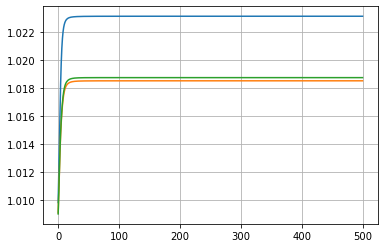

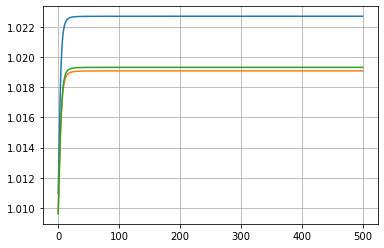

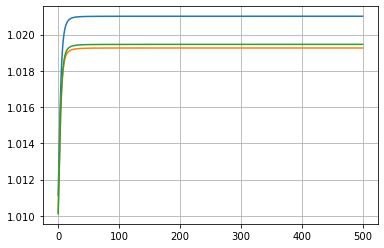

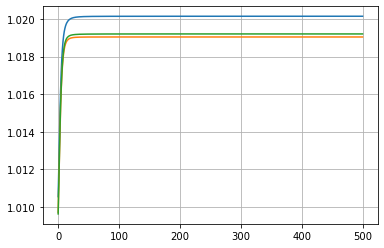

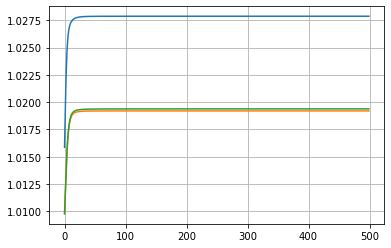

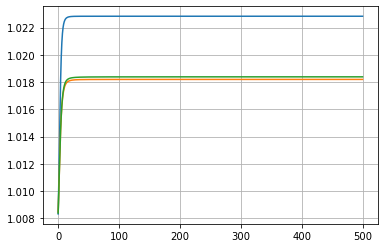

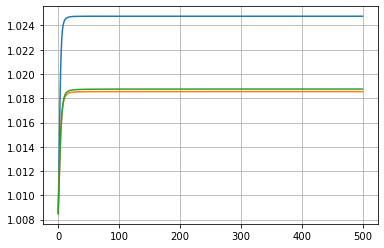

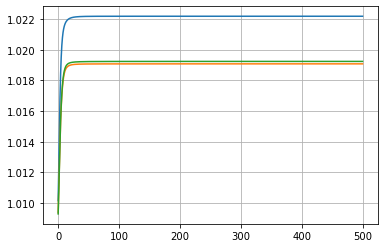

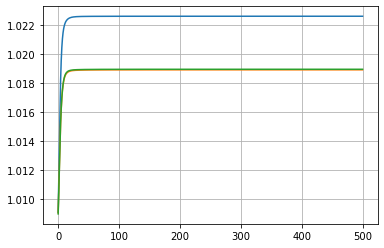

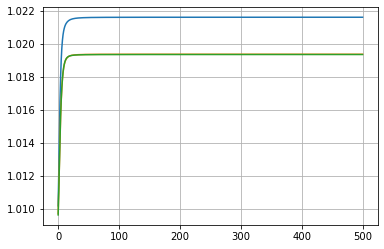

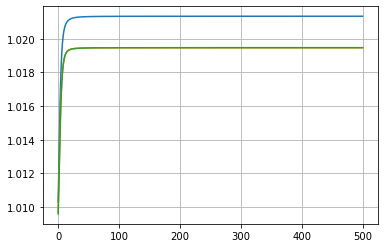

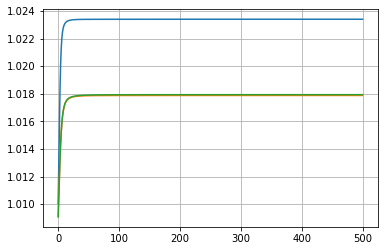

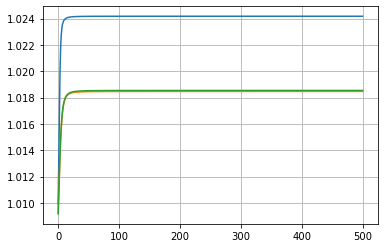

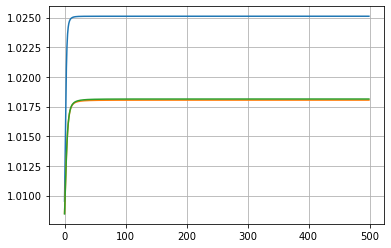

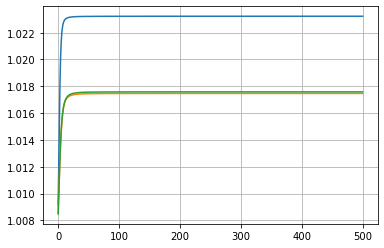

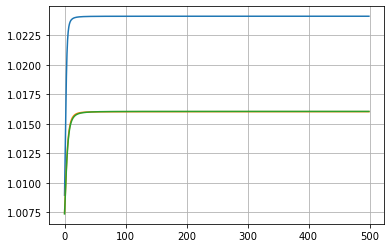

0.8734048517413898
0.26807724756366136
0.24308248807924748


In [10]:
### TEST PORTFOLIOS ###

n_count = 0
rs_performance = np.zeros(T_test[-1]+H-T_train)
fm_performance = np.zeros(T_test[-1]+H-T_train)
em_performance = np.zeros(T_test[-1]+H-T_train)
for t in range(T_train,T_test[-1]+H):
    if t in T_test:
        
        r_test = r[T_test[n_count]-T_train:T_test[n_count],:]
        F_test = F[T_test[n_count]-T_train:T_test[n_count],:]

        μ_f = np.mean(F_test,axis=0)
        Σ_f = np.cov(tsp(F_test))
        
        ### COMPUTE MEAN AND COVARIANCE OF RETURNS ###
        
        # regime-switching factor model
        rsfm = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\rsfm-"+str(n_count)+".npz")     
        p_hat = rsfm['prediction'][-1]
        μ_rs = np.zeros(N)
        Σ_rs = np.zeros((N,N))
        for s in range(S):
            μ_rs += p_hat[s]*(rsfm['alpha'][s]+rsfm['beta'][s]@μ_f)
            Σ_rs += p_hat[s]*(np.outer(rsfm['alpha'][s],rsfm['alpha'][s])+np.outer(rsfm['alpha'][s],rsfm['beta'][s]@μ_f)
                             +np.outer(rsfm['beta'][s]@μ_f,rsfm['alpha'][s])+rsfm['beta'][s]@(Σ_f+np.outer(μ_f,μ_f))@tsp(rsfm['beta'][s])
                             +np.diag(rsfm['sigma'][s]**2))
        Σ_rs = Σ_rs-np.outer(μ_rs,μ_rs)
        
        μ_rs = 1+μ_rs/100
        Σ_rs = Σ_rs/10000
        
        # factor model
        fm = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\fm-"+str(n_count)+".npz")
        μ_fm = fm['alpha']+fm['beta']@μ_f
        Σ_fm = fm['beta']@Σ_f@tsp(fm['beta'])+np.diag(fm['sigma']**2)
        μ_fm = 1+μ_fm/100
        Σ_fm = Σ_fm/10000
        
        # empirical
        em = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\em-"+str(n_count)+".npz")
        μ_em = em['mean']
        Σ_em = em['cov']
        μ_em = 1+μ_em/100
        Σ_em = Σ_em/10000
        
        n_count += 1
        
        ### COMPUTE OPTIMAL WEIGHTS (NO-SHORT SELLING) ###
        
        K = 500
        η = 50
        γ = 1
        
        w_rs, w_rs_hist, u_rs_hist = mvpo_egd(μ_rs,Σ_rs,γ,K,η)
        w_fm, w_fm_hist, u_fm_hist = mvpo_egd(μ_fm,Σ_fm,γ,K,η)
        w_em, w_em_hist, u_em_hist = mvpo_egd(μ_em,Σ_em,γ,K,η)
        
        plt.plot(u_rs_hist)
        plt.plot(u_fm_hist)
        plt.plot(u_em_hist)
        plt.grid()
        plt.show()
        
    ### COMPUTE RETURNS ###
    
    rs_performance[t-T_train] = w_rs@r[t,:]
    fm_performance[t-T_train] = w_fm@r[t,:]
    em_performance[t-T_train] = w_em@r[t,:]

print(np.mean(rs_performance))
print(np.mean(fm_performance))
print(np.mean(em_performance))

In [11]:
# γ_grid = np.arange(0.1,2.0,0.1)
γ_grid = np.concatenate((np.array([0.01]),np.arange(0.05,1.01,0.05)))
rs_grid = np.zeros(len(γ_grid))
fm_grid = np.zeros(len(γ_grid))
em_grid = np.zeros(len(γ_grid))

for g in range(len(γ_grid)):

    ### TEST PORTFOLIOS ###

    n_count = 0
    rs_performance = np.zeros(T_test[-1]+H-T_train)
    fm_performance = np.zeros(T_test[-1]+H-T_train)
    em_performance = np.zeros(T_test[-1]+H-T_train)
    for t in range(T_train,T_test[-1]+H):
        if t in T_test:
            
            r_test = r[T_test[n_count]-T_train:T_test[n_count],:]
            F_test = F[T_test[n_count]-T_train:T_test[n_count],:]

            μ_f = np.mean(F_test,axis=0)
            Σ_f = np.cov(tsp(F_test))

            ### COMPUTE MEAN AND COVARIANCE OF RETURNS ###

            # regime-switching factor model
            rsfm = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\rsfm-"+str(n_count)+".npz")     
            p_hat = rsfm['prediction'][-1]
            μ_rs = np.zeros(N)
            Σ_rs = np.zeros((N,N))
            for s in range(S):
                μ_rs += p_hat[s]*(rsfm['alpha'][s]+rsfm['beta'][s]@μ_f)
                Σ_rs += p_hat[s]*(np.outer(rsfm['alpha'][s],rsfm['alpha'][s])+np.outer(rsfm['alpha'][s],rsfm['beta'][s]@μ_f)
                                 +np.outer(rsfm['beta'][s]@μ_f,rsfm['alpha'][s])+rsfm['beta'][s]@(Σ_f+np.outer(μ_f,μ_f))@tsp(rsfm['beta'][s])
                                 +np.diag(rsfm['sigma'][s]**2))
            Σ_rs = Σ_rs-np.outer(μ_rs,μ_rs)
            μ_rs = 1+μ_rs/100
            Σ_rs = Σ_rs/10000

            # factor model
            fm = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\fm-"+str(n_count)+".npz")
            μ_fm = fm['alpha']+fm['beta']@μ_f
            Σ_fm = fm['beta']@Σ_f@tsp(fm['beta'])+np.diag(fm['sigma']**2)
            μ_fm = 1+μ_fm/100
            Σ_fm = Σ_fm/10000

            # empirical
            em = np.load(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\data\old-i\test\em-"+str(n_count)+".npz")
            μ_em = em['mean']
            Σ_em = em['cov']
            μ_em = 1+μ_em/100
            Σ_em = Σ_em/10000

            n_count += 1

            ### COMPUTE OPTIMAL WEIGHTS (NO-SHORT SELLING) ###

            K = 500
            η = 50
            γ = γ_grid[g]

            w_rs, w_rs_hist, u_rs_hist = mvpo_egd(μ_rs,Σ_rs,γ,K,η)
            w_fm, w_fm_hist, u_fm_hist = mvpo_egd(μ_fm,Σ_fm,γ,K,η)
            w_em, w_em_hist, u_em_hist = mvpo_egd(μ_em,Σ_em,γ,K,η)

            # plt.plot(u_rs_hist)
            # plt.plot(u_fm_hist)
            # plt.plot(u_em_hist)
            # plt.grid()
            # plt.show()

        ### COMPUTE RETURNS ###

        rs_performance[t-T_train] = w_rs@r[t,:]
        fm_performance[t-T_train] = w_fm@r[t,:]
        em_performance[t-T_train] = w_em@r[t,:]
        
    ### RECORD MEAN RETURNS ###
    
    rs_grid[g] = np.mean(rs_performance)
    fm_grid[g] = np.mean(fm_performance)
    em_grid[g] = np.mean(em_performance)
    print(g)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


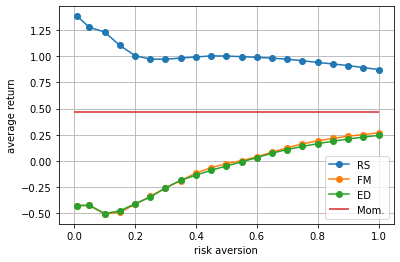

In [12]:
plt.figure(figsize=(6,4))
plt.plot(γ_grid,rs_grid,marker='o')
plt.plot(γ_grid,fm_grid,marker='o')
plt.plot(γ_grid,em_grid,marker='o')
plt.hlines(0.4680,0,1,color='C3')
plt.xlabel("risk aversion")
plt.ylabel("average return")
plt.legend(['RS','FM','ED','Mom.'])
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\portfolio-selection-300.png")
plt.show()